# Intro

- Il problema del forecasting dei prezzi è un problema di regressione affrontato storicamente tramite i classici modelli di serie storiche ARMA-GARCH. Tali modelli consistono in regressioni lineari e, in quanto tali, hanno un bias significativo e non sono in grado di gestire features categoriche.
- Stando alla letteratura "Assets Forecasting with Feature Engineering and Transformation Methods for LightGBM" (https://arxiv.org/abs/2501.07580) gli approcci più di Deep Neural Network più diffusi sono promettenti ma estremamente onerosi computazionalmente e quindi poco accessibili. Un ottimo compromesso per qualità delle previsioni ed efficienza computazionale è il modello LightGBM che verrà utilizzato in questa sfida.
- Per questa sfida ho scelto di utilizzare un indicatore del rischio geopolitico come fonte di dati alternativi, consapevole che sarebbe più opportuno utilizzare indicatori di sentiment daily basati sulle news intraday. Inoltre, come si vede dal grafico sottostante, non sempre una variazione del generico rischio geopolitico si traduce in una variazione di prezzo del petrolio.

# Next Steps

- Lavorare con modelli NLP per ottenere features basate sul sentiment di notizie di mercato (usando ad esempio FINBERT https://huggingface.co/ProsusAI/finbert).
- Considerare i paesi da cui arrivano le notizie (feature categorica).
- Includere come feature il Saudi Energi Sector Index (qui non considerata perchè non ho trovato una serie storica sufficientemente lunga) come suggerito da "Enhancing Multi-Step Brent Oil Price Forecasting with Ensemble Multi-Scenario Bi-GRU Networks" (https://arxiv.org/abs/2407.11267).
- Studiare approfonditamente le correlazioni togliendo outliers e facendo test d'ipotesi.
- Modellizzare adeguatamente stagionalità per costruire features particolarmente informative.

# Fonti dei dati

Ho scelto di utilizzare come base dati da cui estrarre features la serie storica dei prezzi, un indicatore del rischio geopolitico e il US Dollar Index. Le fonti da cui ho scaricato i dati nella cartella data sono le seguenti:
- https://alfred.stlouisfed.org/series?seid=DCOILBRENTEU
- https://www.matteoiacoviello.com/gpr.htm
- https://www.wsj.com/market-data/quotes/index/DXY/historical-prices
- https://www.investing.com/indices/tpisi-historical-data
- https://www.investing.com/commodities/natural-gas-historical-data

# Preprocessing

In [1]:
import pandas as pd

# caricamento della serie storica del prezzo del petrolio
brent_ts = pd.read_csv("data/vintages_starting_2025-06-18.csv")
brent_ts["observation_date"] = pd.to_datetime(brent_ts["observation_date"].astype(str), format="%Y-%m-%d")
# caricamento della serie storica del rischio geopolitico GPR
gpr_ts = pd.read_excel("data/data_gpr_export.xls").loc[:,["month","GPR"]]
gpr_ts["month"] = pd.to_datetime(gpr_ts["month"].astype(str), format="%Y-%m-%d")
# caricamento dati us dollar index
fname_1 = "data/USDX HistoricalPrices.csv"
usdx_ts = pd.read_csv(fname_1)
# caricamento dati TENI 
fname_2 = "data/TENI Historical Data.csv"
teni_ts = pd.read_csv(fname_2)
# caricamento dati gas naturale
fname_3 = "data/Natural Gas Futures Historical Data.csv"
gas_ts = pd.read_csv(fname_3)


In [2]:
brent_ts.head(3)

,observation_date,DCOILBRENTEU_20250618
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55


Aggiungo come feature il GPR dei due mesi precedenti, questa scelta verrà motivata in seguito.

In [3]:
# aggiungo a ciascuna riga il GPR del mese precedente
gpr_ts["GPR_lag_1m"] = gpr_ts["GPR"].shift(1)
gpr_ts["GPR_lag_2m"] = gpr_ts["GPR"].shift(2)

In [4]:
gpr_ts.tail()

,month,GPR,GPR_lag_1m,GPR_lag_2m
1500,2025-01-01,112.333267,142.134567,128.481766
1501,2025-02-01,136.192444,112.333267,142.134567
1502,2025-03-01,175.432983,136.192444,112.333267
1503,2025-04-01,141.136383,175.432983,136.192444
1504,2025-05-01,158.005234,141.136383,175.432983


In [5]:
gpr_ts.info()
brent_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       1505 non-null   datetime64[ns]
 1   GPR         485 non-null    float64       
 2   GPR_lag_1m  484 non-null    float64       
 3   GPR_lag_2m  483 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 47.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9934 entries, 0 to 9933
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   observation_date       9934 non-null   datetime64[ns]
 1   DCOILBRENTEU_20250618  9660 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 155.3 KB


In [6]:
df_dataset = pd.merge(
    left=brent_ts, 
    right=gpr_ts,
    how='left',
    left_on=['observation_date'],
    right_on=['month'],
).ffill().dropna(axis=0).rename(columns={"DCOILBRENTEU_20250618":"BrentPrice"})

In [7]:
df_dataset = df_dataset.drop(columns="month")
# df_dataset.head(30)

In [8]:
usdx_ts.columns

Index(['Date', ' Open', ' High', ' Low', ' Close'], dtype='object')

In [9]:
usdx_ts["Date"] = pd.to_datetime(usdx_ts["Date"], format="%m/%d/%y")
usdx_ts = usdx_ts.drop(columns=[" Open", " High", " Low"])
usdx_ts.tail()

,Date,Close
9781,1987-04-03,97.68
9782,1987-04-02,97.53
9783,1987-04-01,98.11
9784,1987-03-31,97.11
9785,1987-03-30,96.90


In [10]:
df_dataset = pd.merge(
    left=df_dataset, 
    right=usdx_ts,
    how='left',
    left_on=['observation_date'],
    right_on=['Date'],
).dropna(axis=0).rename(columns={" Close": "USDX_price"})
df_dataset = df_dataset.drop(columns="Date")

In [11]:
teni_ts.shape

(4669, 7)

In [12]:
teni_ts["Date"] = pd.to_datetime(teni_ts["Date"], format="%m/%d/%Y")
teni_ts = teni_ts.drop(columns=["Open", "High", "Low", "Vol.","Change %"])
teni_ts["Price"] = teni_ts["Price"].str.replace(",",'').astype(float)
teni_ts.tail()

,Date,Price
4664,2007-01-13,4651.26
4665,2007-01-10,4815.67
4666,2007-01-09,4936.01
4667,2007-01-08,4950.62
4668,2007-01-07,4945.33


In [13]:
df_dataset = pd.merge(
    left=df_dataset, 
    right=teni_ts,
    how='left',
    left_on=['observation_date'],
    right_on=['Date'],
).dropna(axis=0).rename(columns={"Price": "TENI_price"})
df_dataset = df_dataset.drop(columns="Date")

In [14]:
df_dataset.tail()

,observation_date,BrentPrice,GPR,GPR_lag_1m,GPR_lag_2m,USDX_price,TENI_price
9724,2025-06-03,67.48,158.005234,141.136383,175.432983,99.23,4705.77
9725,2025-06-04,66.69,158.005234,141.136383,175.432983,98.79,4704.80
9730,2025-06-11,71.29,158.005234,141.136383,175.432983,98.63,4726.76
9731,2025-06-12,70.84,158.005234,141.136383,175.432983,97.92,4730.05
9733,2025-06-16,75.05,158.005234,141.136383,175.432983,98.00,4793.31


In [15]:
gas_ts["Date"] = pd.to_datetime(gas_ts["Date"], format="%m/%d/%Y")
gas_ts = gas_ts.drop(columns=["Open", "High", "Low", "Vol.","Change %"])
gas_ts.tail()

,Date,Price
4785,2007-01-08,6.378
4786,2007-01-05,6.184
4787,2007-01-04,6.162
4788,2007-01-03,6.163
4789,2007-01-02,6.299


In [16]:
df_dataset = pd.merge(
    left=df_dataset, 
    right=gas_ts,
    how='left',
    left_on=['observation_date'],
    right_on=['Date'],
).dropna(axis=0).rename(columns={"Price": "GAS_price"})
df_dataset = df_dataset.drop(columns="Date")

Ora calcoliamo le varaibili target, ovvero levariazioni di prezzo a 1, 5 e 10 giorni. Lavoro in termini di variazioni di prezzo percentuali per non risentire del cambiamento di ordine di grandezza del prezzo del petrolio nel tempo.

In [17]:
# VARIABILI TARGET
df_dataset["1d_pct_price_var"] = df_dataset["BrentPrice"].pct_change().shift(-1)
df_dataset["5d_pct_price_var"] = df_dataset["BrentPrice"].pct_change(5).shift(-5)
df_dataset["10d_pct_price_var"] = df_dataset["BrentPrice"].pct_change(10).shift(-10)
# FEATURES NOTE AL TEMPO DELLA PREVISIONE
df_dataset["1d_pct_price_var_lag_0"] = df_dataset["BrentPrice"].pct_change()
df_dataset["5d_pct_price_var_lag_0"] = df_dataset["BrentPrice"].pct_change(5)
df_dataset["10d_pct_price_var_lag_0"] = df_dataset["BrentPrice"].pct_change(10)

df_dataset["USDX_1d_pct_price_var_lag_0"] = df_dataset["USDX_price"].pct_change()
df_dataset["USDX_5d_pct_price_var_lag_0"] = df_dataset["USDX_price"].pct_change(5)
df_dataset["USDX_10d_pct_price_var_lag_0"] = df_dataset["USDX_price"].pct_change(10)

df_dataset["TENI_1d_pct_price_var_lag_0"] = df_dataset["TENI_price"].pct_change()
df_dataset["TENI_5d_pct_price_var_lag_0"] = df_dataset["TENI_price"].pct_change(5)
df_dataset["TENI_10d_pct_price_var_lag_0"] = df_dataset["TENI_price"].pct_change(10)

df_dataset["GAS_1d_pct_price_var_lag_0"] = df_dataset["GAS_price"].pct_change()
df_dataset["GAS_5d_pct_price_var_lag_0"] = df_dataset["GAS_price"].pct_change(5)
df_dataset["GAS_10d_pct_price_var_lag_0"] = df_dataset["GAS_price"].pct_change(10)

df_dataset["Brent-USDX"] = df_dataset["BrentPrice"] - df_dataset["USDX_price"]
df_dataset["Brent-TENI"] = df_dataset["BrentPrice"] - df_dataset["TENI_price"]
df_dataset["Brent-GAS"] = df_dataset["BrentPrice"] - df_dataset["GAS_price"]

df_dataset["Brent-USDX_1d_pct_price_var_lag_0"] = df_dataset["Brent-USDX"].pct_change()
df_dataset["Brent-TENI_1d_pct_price_var_lag_0"] = df_dataset["Brent-TENI"].pct_change() 
df_dataset["Brent-GAS_1d_pct_price_var_lag_0"] = df_dataset["Brent-GAS"].pct_change() 

df_dataset = df_dataset.dropna(axis=0)
df_dataset.head(6)

,observation_date,BrentPrice,GPR,GPR_lag_1m,GPR_lag_2m,USDX_price,TENI_price,GAS_price,1d_pct_price_var,5d_pct_price_var,...,TENI_10d_pct_price_var_lag_0,GAS_1d_pct_price_var_lag_0,GAS_5d_pct_price_var_lag_0,GAS_10d_pct_price_var_lag_0,Brent-USDX,Brent-TENI,Brent-GAS,Brent-USDX_1d_pct_price_var_lag_0,Brent-TENI_1d_pct_price_var_lag_0,Brent-GAS_1d_pct_price_var_lag_0
10,2007-01-31,56.52,97.920044,90.606560,88.778923,84.61,4778.11,7.667,0.038040,-0.007077,...,-0.034846,-0.009432,0.047547,0.202101,-28.09,-4721.59,48.853,-0.074160,0.017499,0.040532
11,2007-02-05,58.67,96.169357,97.920044,90.606560,85.08,4883.15,7.634,-0.010738,-0.061701,...,-0.010709,-0.004304,0.004870,0.151259,-26.41,-4824.48,51.036,-0.059808,0.021791,0.044685
12,2007-02-06,58.04,96.169357,97.920044,90.606560,84.78,5030.99,7.616,0.005341,-0.036699,...,0.044712,-0.002358,0.026277,0.127461,-26.74,-4972.95,50.424,0.012495,0.030774,-0.011992
13,2007-02-07,58.35,96.169357,97.920044,90.606560,84.75,5080.56,7.709,-0.048500,-0.010454,...,0.110937,0.012211,0.114501,0.161344,-26.40,-5022.21,50.641,-0.012715,0.009906,0.004304
14,2007-02-12,55.52,96.169357,97.920044,90.606560,85.15,5219.96,7.226,0.010807,0.086816,...,0.144296,-0.062654,-0.066408,0.159127,-29.63,-5164.44,48.294,0.122348,0.028320,-0.046346
15,2007-02-13,56.12,96.169357,97.920044,90.606560,84.73,5288.53,7.367,-0.019066,0.074127,...,0.106288,0.019513,-0.039129,0.006558,-28.61,-5232.41,48.753,-0.034425,0.013161,0.009504


## Brent Price and GPR visualization

In [18]:
import plotly.graph_objects as go

fig = go.Figure()

# First line - Brent Price (left y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["BrentPrice"],
    name="Brent Price",
    yaxis="y1",
    line=dict(color="blue")
))

# Second line - GPR (right y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["GPR"],
    name="GPR",
    yaxis="y2",
    line=dict(color="red")
))

# Layout with two y-axes
fig.update_layout(
    title="Brent Price and GPR Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Brent Price",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="GPR",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


I picchi del GPR corrispondono a importanti crisi geopolitiche e, diverse volte, all'aumento del prezzo del petrolio

## Brent Price and USDX

In [19]:
import plotly.graph_objects as go

fig = go.Figure()

# First line - Brent Price (left y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["BrentPrice"],
    name="Brent Price",
    yaxis="y1",
    line=dict(color="blue")
))

# Second line - USDX (right y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["USDX_price"],
    name="USDX",
    yaxis="y2",
    line=dict(color="red")
))

# Layout with two y-axes
fig.update_layout(
    title="Brent Price and USDX Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Brent Price",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="USDX",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


## Brent Price and TENI

In [20]:
import plotly.graph_objects as go

fig = go.Figure()

# First line - Brent Price (left y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["BrentPrice"],
    name="Brent Price",
    yaxis="y1",
    line=dict(color="blue")
))

# Second line - TENI (right y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["TENI_price"],
    name="TENI",
    yaxis="y2",
    line=dict(color="red")
))

# Layout with two y-axes
fig.update_layout(
    title="Brent Price and TENI Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Brent Price",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="TENI",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


## Brent Price and Gas Price

In [21]:
import plotly.graph_objects as go

fig = go.Figure()

# First line - Brent Price (left y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["BrentPrice"],
    name="Brent Price",
    yaxis="y1",
    line=dict(color="blue")
))

# Second line - GAS (right y-axis)
fig.add_trace(go.Scatter(
    x=df_dataset["observation_date"],
    y=df_dataset["GAS_price"],
    name="GAS",
    yaxis="y2",
    line=dict(color="red")
))

# Layout with two y-axes
fig.update_layout(
    title="Brent Price and GAS Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Brent Price",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue")
    ),
    yaxis2=dict(
        title="GAS",
        titlefont=dict(color="red"),
        tickfont=dict(color="red"),
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


## ACF

Per decidere quante variazioni di prezzo passate considerare, visualizzo l'ACF.

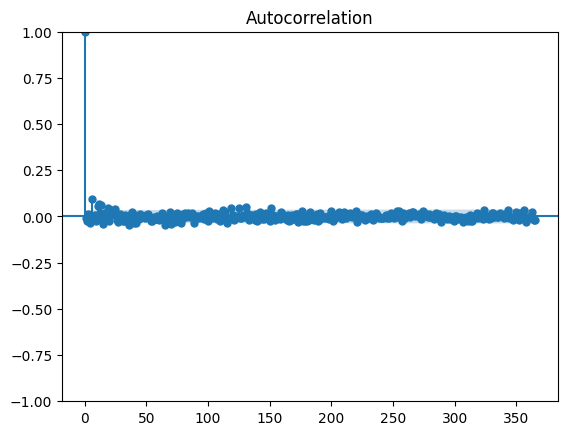

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pylab as plt

plot_acf(df_dataset["1d_pct_price_var_lag_0"],lags=365)
plt.show()

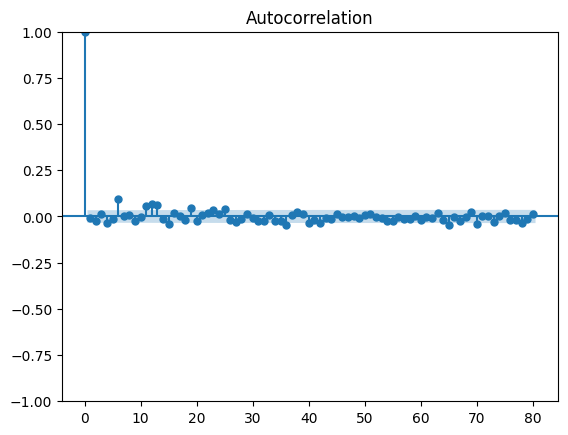

In [23]:
plot_acf(df_dataset["1d_pct_price_var_lag_0"],lags=80)
plt.show()

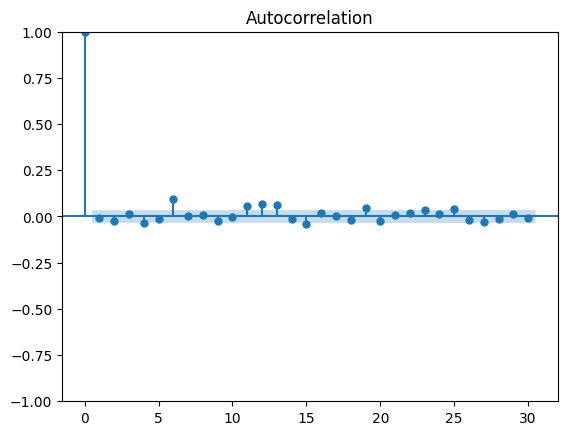

In [24]:
plot_acf(df_dataset["1d_pct_price_var_lag_0"],lags=30)
plt.show()

Si nota la presenza di autocorrelazioni staticamente significative anche per lag molto grandi. Ciò può essere segno di dinamiche stagionali che però sono difficili da identificare ad occhio nudo. Ai fini di questa sfida mi limiterò a considerare le variazioni di prezzo fino a 15 giorni.

In [25]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13]

for i in lags:
    df_dataset[f"1d_pct_price_var_lag_{i}"] = df_dataset["1d_pct_price_var_lag_0"].shift(i)
    df_dataset[f"USDX_1d_pct_price_var_lag_{i}"] = df_dataset["USDX_1d_pct_price_var_lag_0"].shift(i)
    df_dataset[f"GAS_1d_pct_price_var_lag_{i}"] = df_dataset["GAS_1d_pct_price_var_lag_0"].shift(i)
    df_dataset[f"TENI_1d_pct_price_var_lag_{i}"] = df_dataset["TENI_1d_pct_price_var_lag_0"].shift(i)
    df_dataset[f"Brent-USDX_1d_pct_price_var_lag_{i}"] = df_dataset["Brent-USDX_1d_pct_price_var_lag_0"].shift(i)
    df_dataset[f"Brent-TENI_1d_pct_price_var_lag_{i}"] = df_dataset["Brent-TENI_1d_pct_price_var_lag_0"].shift(i)
    df_dataset[f"Brent-GAS_1d_pct_price_var_lag_{i}"] = df_dataset["Brent-GAS_1d_pct_price_var_lag_0"].shift(i)

df_dataset = df_dataset.dropna(axis=0)

C:\Users\volpe\AppData\Local\Temp\ipykernel_7240\546391069.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\volpe\AppData\Local\Temp\ipykernel_7240\546391069.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\volpe\AppData\Local\Temp\ipykernel_7240\546391069.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

Aggiungo come feature la differenza tra il prezzo di oggi e la media mobile a 7 e 15 periodi 

In [26]:
df_dataset["Today-15_ma"] = pd.Series.rolling(df_dataset["BrentPrice"],window=15).mean() - df_dataset["BrentPrice"]
df_dataset["Today-7_ma"] = pd.Series.rolling(df_dataset["BrentPrice"],window=7).mean() - df_dataset["BrentPrice"]

df_dataset["USDX-Today-15_ma"] = pd.Series.rolling(df_dataset["USDX_price"],window=15).mean() - df_dataset["USDX_price"]
df_dataset["USDX-Today-7_ma"] = pd.Series.rolling(df_dataset["USDX_price"],window=7).mean() - df_dataset["USDX_price"]

df_dataset["TENI-Today-15_ma"] = pd.Series.rolling(df_dataset["TENI_price"],window=15).mean() - df_dataset["TENI_price"]
df_dataset["TENI-Today-7_ma"] = pd.Series.rolling(df_dataset["TENI_price"],window=7).mean() - df_dataset["TENI_price"]

df_dataset["GAS-Today-15_ma"] = pd.Series.rolling(df_dataset["GAS_price"],window=15).mean() - df_dataset["GAS_price"]
df_dataset["GAS-Today-7_ma"] = pd.Series.rolling(df_dataset["GAS_price"],window=7).mean() - df_dataset["GAS_price"]

df_dataset = df_dataset.dropna(axis=0)
df_dataset.head()

C:\Users\volpe\AppData\Local\Temp\ipykernel_7240\299817687.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\volpe\AppData\Local\Temp\ipykernel_7240\299817687.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\volpe\AppData\Local\Temp\ipykernel_7240\299817687.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

,observation_date,BrentPrice,GPR,GPR_lag_1m,GPR_lag_2m,USDX_price,TENI_price,GAS_price,1d_pct_price_var,5d_pct_price_var,...,Brent-TENI_1d_pct_price_var_lag_13,Brent-GAS_1d_pct_price_var_lag_13,Today-15_ma,Today-7_ma,USDX-Today-15_ma,USDX-Today-7_ma,TENI-Today-15_ma,TENI-Today-7_ma,GAS-Today-15_ma,GAS-Today-7_ma
37,2007-04-09,69.15,87.336502,96.169357,97.920044,83.10,5813.33,7.546,-0.021837,-0.058713,...,0.033820,0.029804,-5.576667,-2.148571,0.201333,-0.071429,116.938000,-168.551429,-0.271667,-0.049857
38,2007-04-10,67.64,87.336502,96.169357,97.920044,82.70,5876.41,7.869,0.014193,-0.012419,...,0.020296,-0.001600,-3.536000,-0.180000,0.510000,0.274286,51.281333,-216.801429,-0.568200,-0.285000
39,2007-04-11,68.60,87.336502,96.169357,97.920044,82.67,5823.62,7.855,-0.021866,-0.009621,...,-0.035395,0.017698,-3.998000,-0.518571,0.466000,0.255714,84.676667,-153.010000,-0.521600,-0.220714
40,2007-04-16,67.10,87.336502,96.169357,97.920044,82.07,5599.42,7.530,-0.011326,0.005067,...,0.027862,-0.015029,-2.064000,1.117143,0.946667,0.718571,266.380667,64.664286,-0.155400,0.100286
41,2007-04-17,66.34,87.336502,96.169357,97.920044,81.83,5560.68,7.418,-0.018842,0.013416,...,0.026424,-0.003048,-0.982667,1.505714,1.060000,0.810000,274.554000,112.361429,-0.008333,0.176143


# Matrice di correlazione e salvataggio del csv

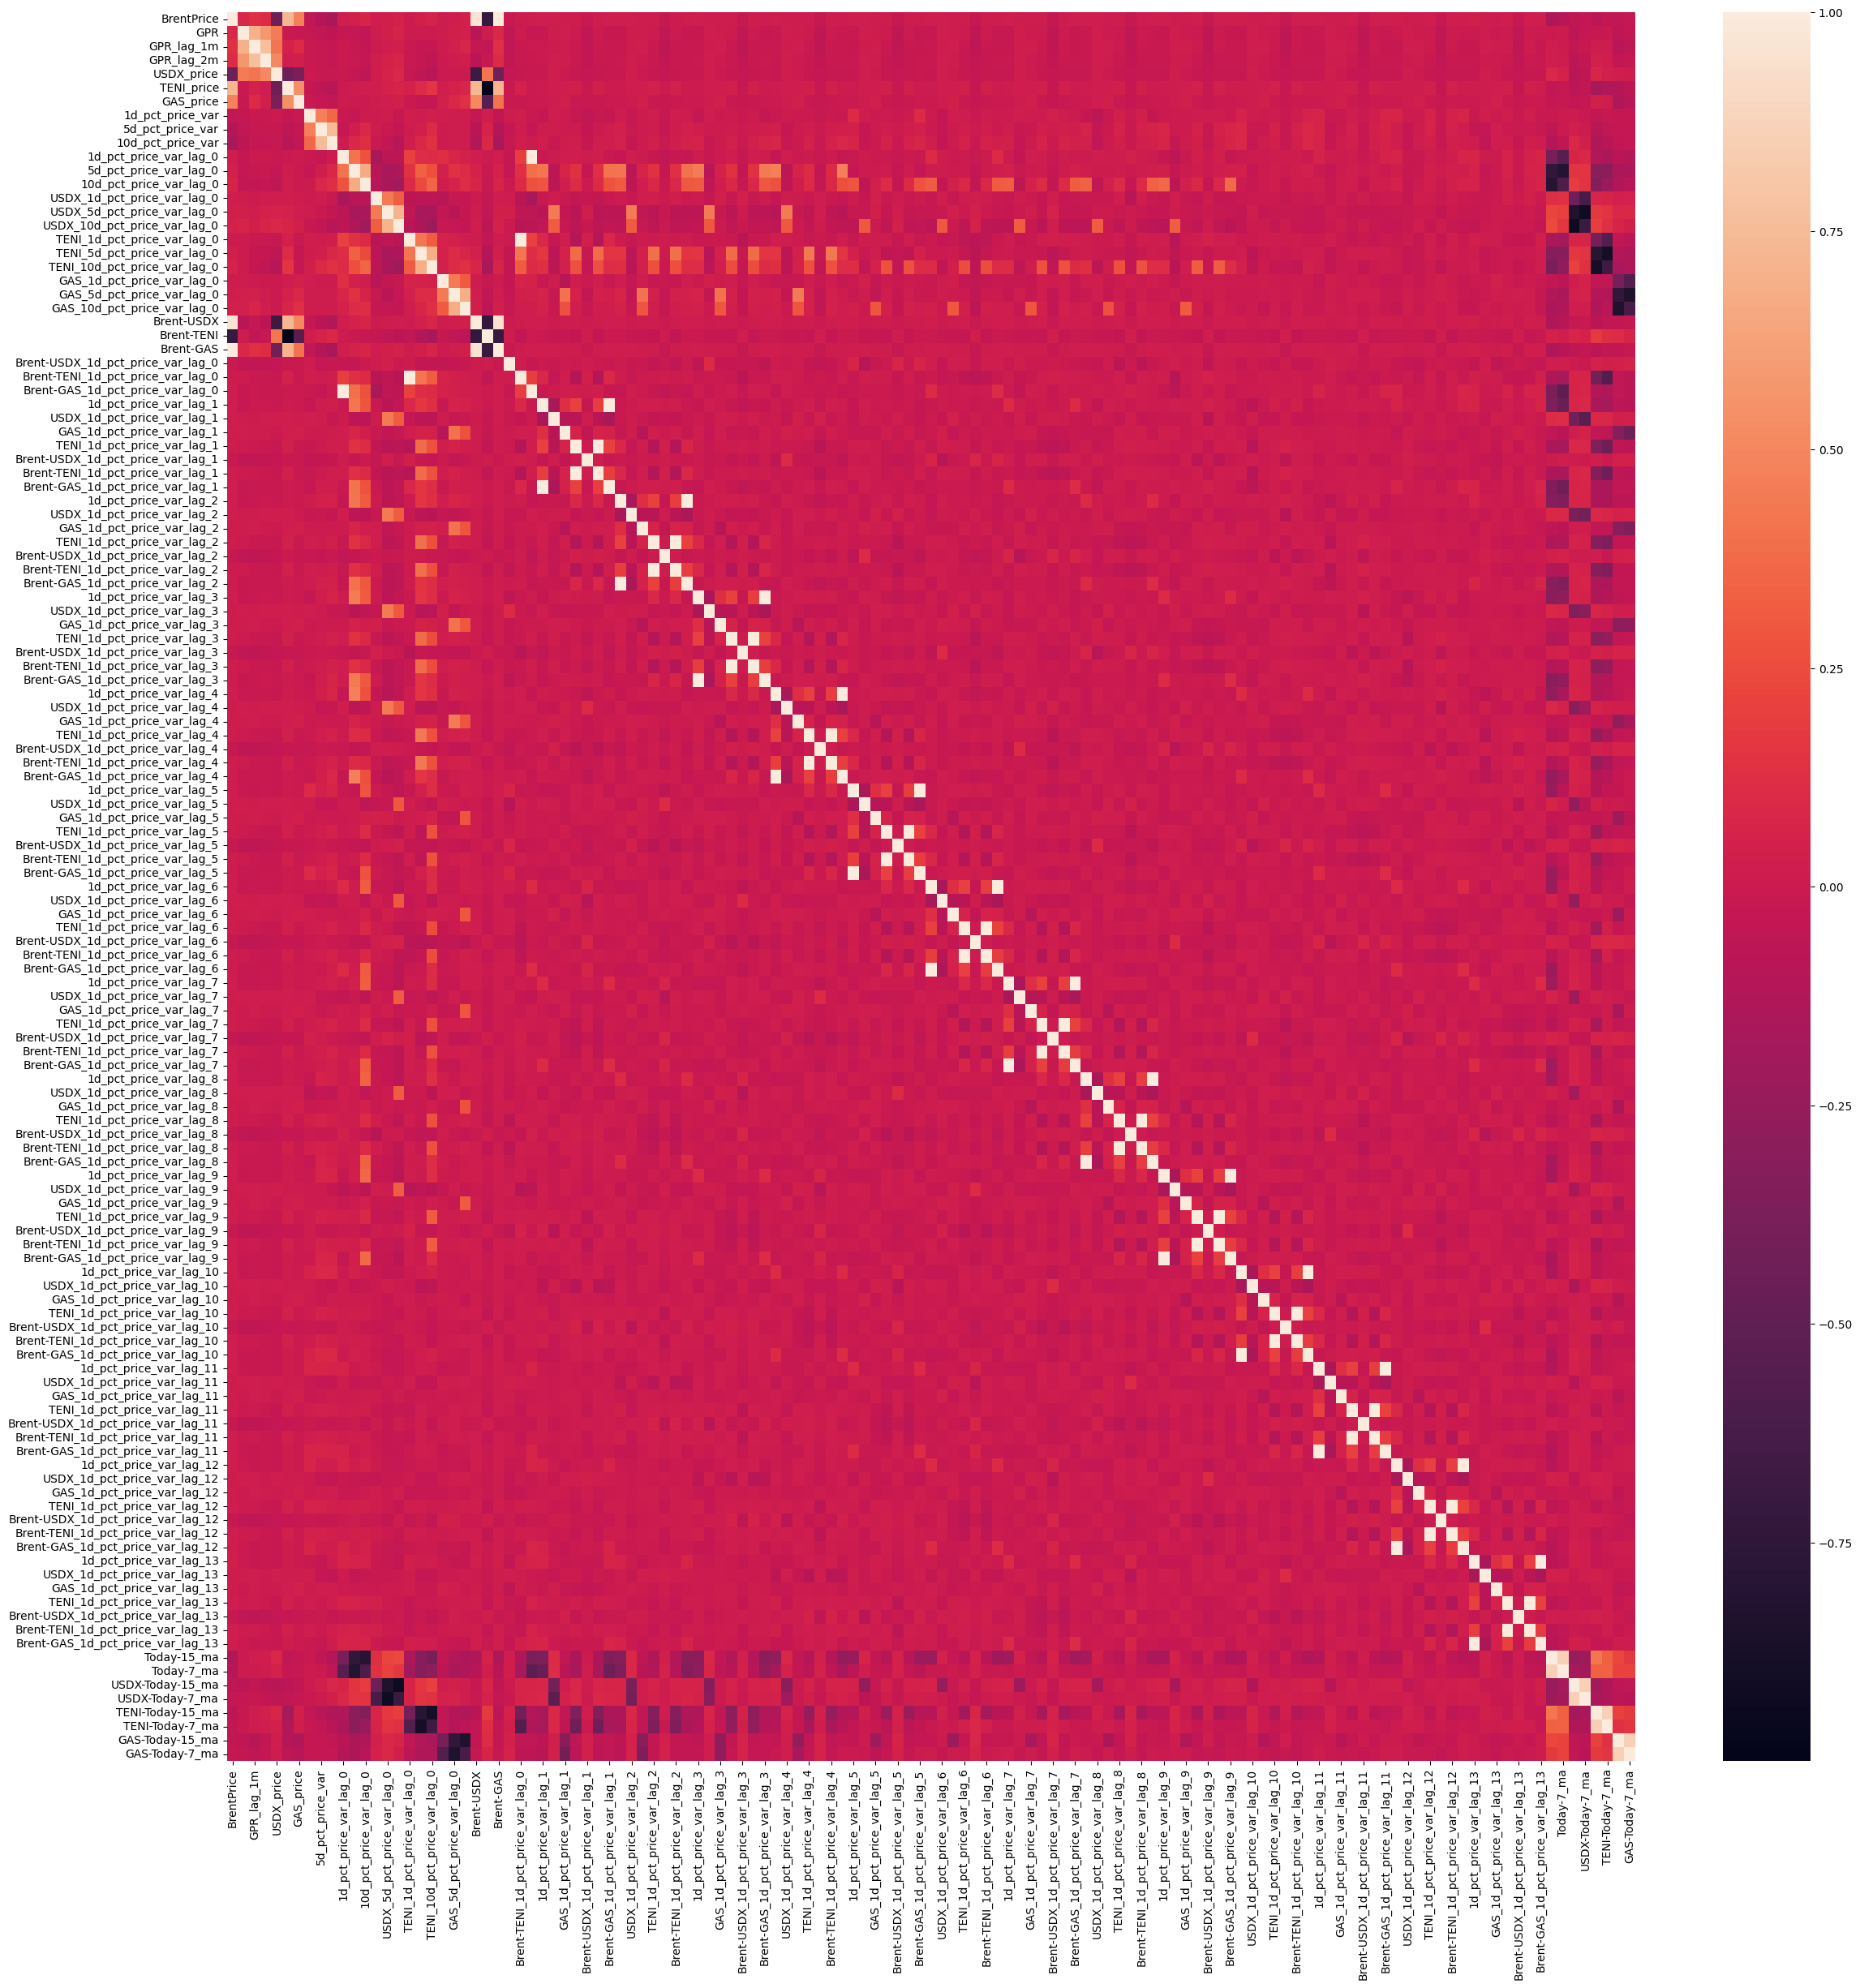

In [27]:
import seaborn as sns
import matplotlib.pylab as plt

plt.figure(figsize=(28, 28))
sns.heatmap(df_dataset.corr(numeric_only=True),annot=False,fmt=".2f")
plt.show()

In [28]:
df_dataset = df_dataset.drop(columns=["BrentPrice", "USDX_price","GAS_price","TENI_price"])

In [29]:
df_dataset.to_csv("preprocessed_dataset.csv")